In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools
import seaborn as sns

sns.set_style("whitegrid")

In [4]:
drugs = pd.DataFrame({
    "drug name": ["aspirin", "paracetamol", "pseudoefedrin", "sulfogaiacol"],
    "canonical_smiles": ["CC(=O)Oc1ccccc1C(=O)O", "CC(=O)Nc1ccc(cc1)O", "CNC(C(c1ccccc1)O)C", "OC1=CC=CC=C1OC.O=S([O-])(C)=O.[K+]"]
})

In [5]:
drugs

,drug name,canonical_smiles
0,aspirin,CC(=O)Oc1ccccc1C(=O)O
1,paracetamol,CC(=O)Nc1ccc(cc1)O
2,pseudoefedrin,CNC(C(c1ccccc1)O)C
3,sulfogaiacol,OC1=CC=CC=C1OC.O=S([O-])(C)=O.[K+]


In [6]:
# Add ROMol objects to the dataframe
drugs['ROMol'] = drugs['canonical_smiles'].apply(Chem.MolFromSmiles)

# Calculate descriptors
drugs['MolecularMass'] = drugs['ROMol'].apply(lambda x: Descriptors.MolWt(x) if x is not None else None)
drugs['NumHAcceptors'] = drugs['ROMol'].apply(lambda x: Descriptors.NumHAcceptors(x) if x is not None else None)
drugs['NumHDonors'] = drugs['ROMol'].apply(lambda x: Descriptors.NumHDonors(x) if x is not None else None)
drugs['LogP'] = drugs['ROMol'].apply(lambda x: Descriptors.MolLogP(x) if x is not None else None)

# Display the dataframe with new descriptors
drugs[['drug name', 'canonical_smiles', 'MolecularMass', 'NumHAcceptors', 'NumHDonors', 'LogP']]

,drug name,canonical_smiles,MolecularMass,NumHAcceptors,NumHDonors,LogP
0,aspirin,CC(=O)Oc1ccccc1C(=O)O,180.159,3,1,1.3101
1,paracetamol,CC(=O)Nc1ccc(cc1)O,151.165,2,2,1.3506
2,pseudoefedrin,CNC(C(c1ccccc1)O)C,165.236,2,2,1.3279
3,sulfogaiacol,OC1=CC=CC=C1OC.O=S([O-])(C)=O.[K+],258.336,5,1,-2.4338


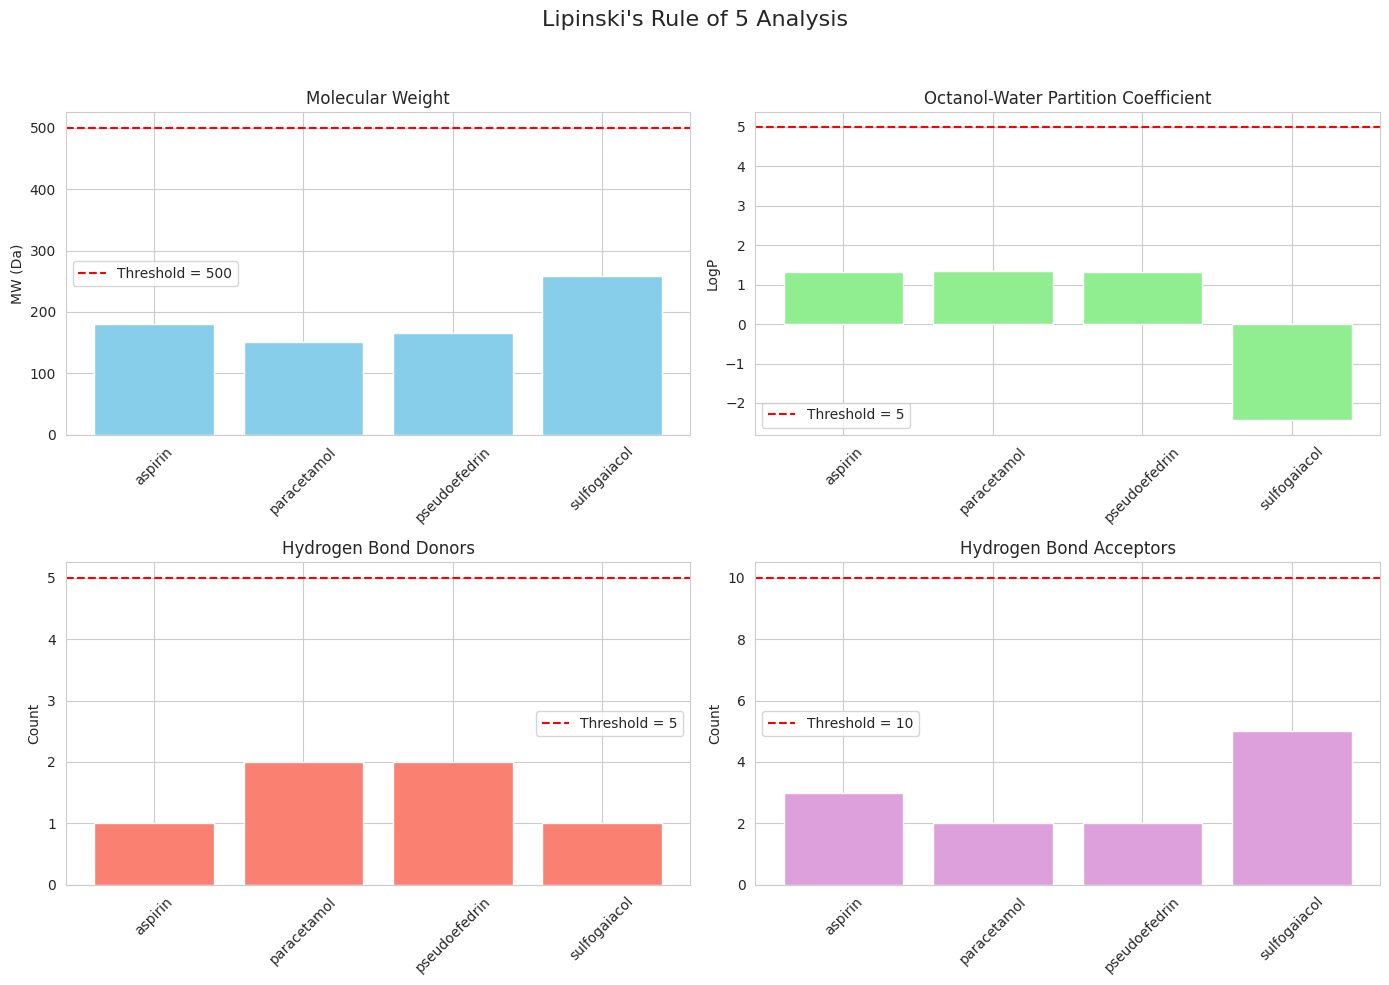

In [7]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Lipinski's Rule of 5 Analysis", fontsize=16)

# Plot Molecular Weight (< 500)
axs[0, 0].bar(drugs['drug name'], drugs['MolecularMass'], color='skyblue')
axs[0, 0].axhline(y=500, color='red', linestyle='--', label='Threshold = 500')
axs[0, 0].set_title('Molecular Weight')
axs[0, 0].set_ylabel('MW (Da)')
axs[0, 0].tick_params(axis='x', rotation=45)
axs[0, 0].legend()

# Plot LogP (< 5)
axs[0, 1].bar(drugs['drug name'], drugs['LogP'], color='lightgreen')
axs[0, 1].axhline(y=5, color='red', linestyle='--', label='Threshold = 5')
axs[0, 1].set_title('Octanol-Water Partition Coefficient')
axs[0, 1].set_ylabel('LogP')
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 1].legend()

# Plot H-bond Donors (< 5)
axs[1, 0].bar(drugs['drug name'], drugs['NumHDonors'], color='salmon')
axs[1, 0].axhline(y=5, color='red', linestyle='--', label='Threshold = 5')
axs[1, 0].set_title('Hydrogen Bond Donors')
axs[1, 0].set_ylabel('Count')
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].legend()

# Plot H-bond Acceptors (< 10)
axs[1, 1].bar(drugs['drug name'], drugs['NumHAcceptors'], color='plum')
axs[1, 1].axhline(y=10, color='red', linestyle='--', label='Threshold = 10')
axs[1, 1].set_title('Hydrogen Bond Acceptors')
axs[1, 1].set_ylabel('Count')
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [8]:
def check_lipinski(smiles):
    """
    Check if a molecule follows Lipinski's Rule of 5.
    Returns True if the molecule passes at least 3 out of 4 rules.
    
    Lipinski's Rule of 5:
    - Molecular mass < 500 Da
    - LogP < 5
    - H-bond donors <= 5
    - H-bond acceptors <= 10
    """
    # Create molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return False, "Invalid SMILES"
    
    # Calculate properties
    molecular_mass = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    h_donors = Descriptors.NumHDonors(mol)
    h_acceptors = Descriptors.NumHAcceptors(mol)
    
    # Check each rule
    mass_passed = molecular_mass < 500
    logp_passed = logp < 5
    donors_passed = h_donors <= 5
    acceptors_passed = h_acceptors <= 10
    
    # Count passed rules
    rules_passed = sum([mass_passed, logp_passed, donors_passed, acceptors_passed])
    
    # Overall result - pass if at least 3 out of 4 rules are satisfied
    passed = rules_passed >= 3
    
    return pd.DataFrame({
        "passed": [passed],
        "Molecular mass": [molecular_mass],
        "LogP": [logp],
        "H-Donors": [h_donors],
        "H-Acceptors": [h_acceptors]
    })

In [9]:
import os

In [10]:
EGFR_df = pd.read_csv(os.path.join("..", "1_baza_chembl", "EGFR_combined.csv"))

In [11]:
EGFR_df.head()

,activity_id,assay_chembl_id,molecule_chembl_id,type,units,IC50,pIC50,canonical smiles
0,306817,CHEMBL649260,CHEMBL2114210,IC50,uM,110000.0,0.958607,OC[C@H]1N[C@H](CO)[C@@H](O)C(O)[C@@H]1O
1,333831,CHEMBL816395,CHEMBL2093897,IC50,uM,8400.0,2.075721,OC[C@@H]1N[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
2,437093,CHEMBL710107,CHEMBL77918,IC50,uM,50000.0,1.301030,CCCCN1[C@H](CO)[C@@H](O)[C@H](O)[C@H]1CO
3,441033,CHEMBL710106,CHEMBL307429,IC50,uM,360.0,3.443697,OC[C@H]1NC[C@H](O)[C@@H](O)[C@@H]1O
4,854643,CHEMBL646887,CHEMBL44,IC50,uM,10400.0,1.982967,O=c1c(-c2ccc(O)cc2)coc2cc(O)cc(O)c12


In [12]:
lipinski_results = EGFR_df['canonical smiles'].map(check_lipinski)

In [13]:
lipinski_results[0]

,passed,Molecular mass,LogP,H-Donors,H-Acceptors
0,True,193.199,-3.6059,6,6


In [14]:
# Extract all lipinski results into a list of dataframes
lipinski_results_df_list = [df for df in lipinski_results]

# Combine results and add molecule identifiers
all_results = pd.DataFrame()
for i, result_df in enumerate(lipinski_results_df_list):
    result_df['molecule_name'] = EGFR_df.iloc[i]['molecule_chembl_id']
    result_df['canonical_smiles'] = EGFR_df.iloc[i]['canonical smiles']
    all_results = pd.concat([all_results, result_df], ignore_index=True)

# Filter only compounds that pass Lipinski's rule
lipinski_compliant = all_results[all_results['passed'] == True].reset_index(drop=True)

# Display the filtered results
print(f"Found {len(lipinski_compliant)} compounds that pass Lipinski's rule out of {len(EGFR_df)} total.")
lipinski_compliant[['molecule_name', 'Molecular mass', 'LogP', 'H-Donors', 'H-Acceptors', 'passed']]

Found 25 compounds that pass Lipinski's rule out of 29 total.


,molecule_name,Molecular mass,LogP,H-Donors,H-Acceptors,passed
0,CHEMBL2114210,193.199,-3.60590,6,6,True
1,CHEMBL2093897,193.199,-3.60590,6,6,True
2,CHEMBL77918,219.281,-1.45430,4,5,True
3,CHEMBL307429,163.173,-2.96680,5,5,True
4,CHEMBL44,270.240,2.57680,3,5,True
5,CHEMBL380336,438.564,4.72360,1,5,True
6,CHEMBL241374,410.510,4.40190,2,5,True
7,CHEMBL574645,397.556,1.14890,4,6,True
8,CHEMBL3407617,403.463,4.44140,2,6,True
9,CHEMBL3814747,304.792,-5.92680,5,6,True


In [ ]:
# lipinski_compliant.to_csv("EGFR_lipinski.csv", index=False)

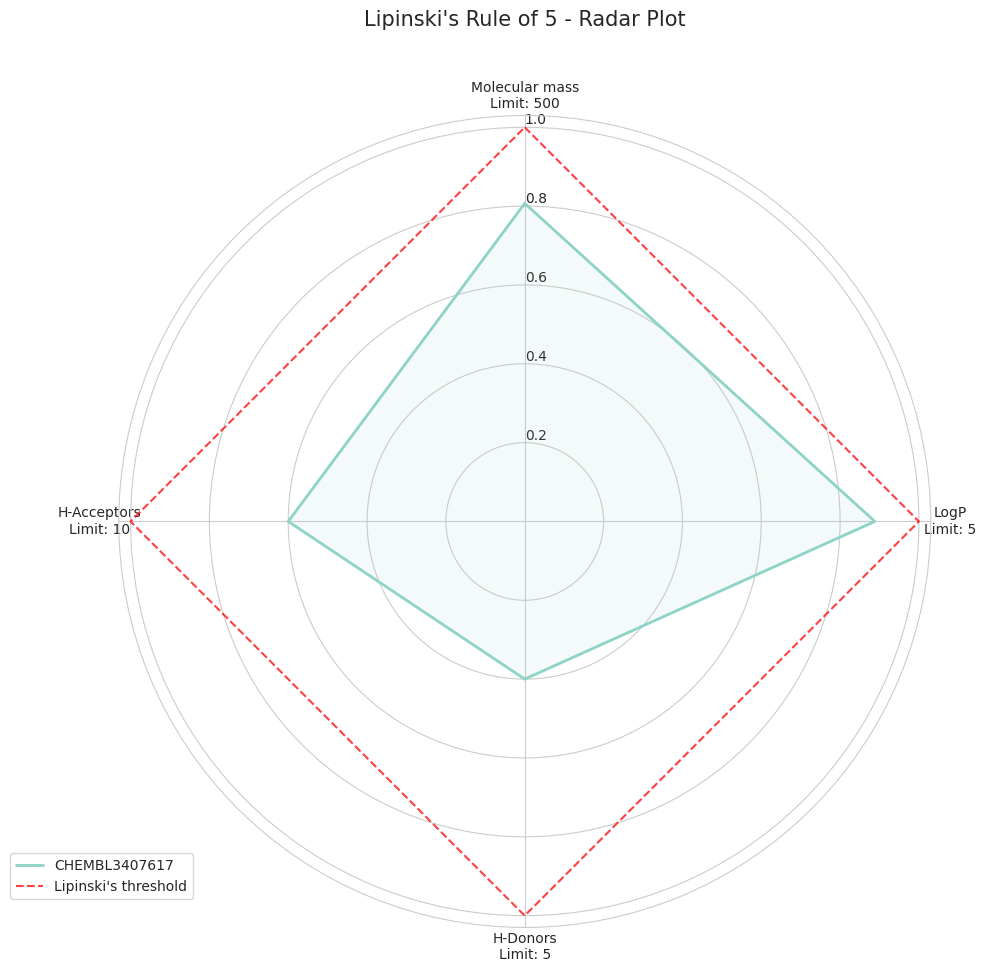

In [15]:
# Create a function for spider/radar plots of compounds
def create_lipinski_radar_plot(df, compounds=None, max_compounds=5):
    """
    Create a radar plot showing Lipinski's parameters for selected compounds
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing Lipinski's parameters
    compounds : list, optional
        List of molecule names to include in the plot
    max_compounds : int, optional
        Maximum number of compounds to display if compounds is None
    """
    # If no compounds specified, select the first max_compounds
    if compounds is None:
        compounds = df['molecule_name'].unique()[:max_compounds]
    else:
        # Ensure all compounds exist in the dataframe
        compounds = [c for c in compounds if c in df['molecule_name'].values]
    
    # Filter dataframe to include only selected compounds
    plot_df = df[df['molecule_name'].isin(compounds)]
    
    # Parameters for the radar plot
    categories = ['Molecular mass', 'LogP', 'H-Donors', 'H-Acceptors']
    
    # Normalize the values for better visualization
    # Set max values based on Lipinski's rule of 5
    max_values = {
        'Molecular mass': 500,
        'LogP': 5,
        'H-Donors': 5,
        'H-Acceptors': 10
    }
    
    # Number of variables
    N = len(categories)
    
    # Create figure and polar subplot
    fig = plt.figure(figsize=(10,20))
    ax = fig.add_subplot(111, polar=True)
    
    # Angle for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Add reference circles for Lipinski's thresholds
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    
    # Plot each compound
    for i, name in enumerate(compounds):
        values = plot_df[plot_df['molecule_name'] == name][categories].values[0]
        # Normalize values
        normalized_values = [values[i] / max_values[categories[i]] for i in range(len(categories))]
        normalized_values += normalized_values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, normalized_values, linewidth=2, linestyle='solid', label=name)
        ax.fill(angles, normalized_values, alpha=0.1)
    
    # Set category labels
    plt.xticks(angles[:-1], [f"{cat}\nLimit: {max_values[cat]}" for cat in categories])
    
    # Draw threshold line
    ax.plot(angles, [1] * (N + 1), linewidth=1.5, linestyle='--', color='red', alpha=0.75, label="Lipinski's threshold")
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title("Lipinski's Rule of 5 - Radar Plot", size=15, y=1.1)
    plt.grid(True)
    
    return fig, ax

# Create radar plot for 5 diverse compounds from the dataset
selected_compounds = lipinski_compliant['molecule_name'].sample(1, random_state=42).tolist()
fig, ax = create_lipinski_radar_plot(lipinski_compliant, compounds=selected_compounds)
plt.tight_layout()
plt.show()